# SURFER

In [1]:
using DifferentialEquations
using Plots
using DelimitedFiles
using Interpolations
using Roots
using LaTeXStrings

In [2]:
pyplot()

Plots.PyPlotBackend()

## model parameters and auxiliary expressions

In [3]:
#-----------------------------------------------------
# fixed CarbonCycle+Aerosol parameters
#-----------------------------------------------------
ka = 1/4              # 1/years
hup = 150             # m. Thickness of upper ocean layer
hlo =  hup*20         # m. Thickness of lower ocean layer
δ = hlo/hup           # h_L/h_U dimensionless 
δDIC = 1.15           # dimensionless DIC_L/DIC_U at pre industrial
kd = (δ*δDIC)/1000    # 1/years
K0 = 0.0314806         # mol/(kg atm) Henry CO2 solubility
K1 = 1.32648E-6        # mol/kg
K2 = 9.19803E-10     # mol/kg
mA = 1.727E20         # moles in atmosphere
mO = 7.8E22           # moles in ocean
GtCtoppm(Mat) = (Mat * 1E6 * 1E15)/(12*mA) # ppm in atmosphere/ PgC in atmosphere
ppmtoGtC(conc) = conc*12*mA/(1E21)
Wup = mO*18E-3*hup/(hup+hlo) # whole upper ocean mass kg
Wlo = mO*18E-3*hlo/(hup+hlo) # whole lower ocean mass kg
pH_PI = 8.17
H_PI = 10^(-pH_PI) # mol/kg
CO2conc_a_PI = 280 # ppm
pCO2_a(CO2conc_a) = CO2conc_a*1E-6 # atm
Q = (K1/H_PI + 2*K1*K2/H_PI^2)*K0*pCO2_a(CO2conc_a_PI) # mol/kg
Qm = Q*Wup*12E-3*1E-12 # PgC
kla = 1/40            #1/yr
βla = 1.7
#-----------------------------------------------------
# pre industrial initial conditions for the carbon reservoirs
#-----------------------------------------------------
Mat_PI = ppmtoGtC(CO2conc_a_PI) # PgC
Mup_PI = Mat_PI*(1 + K1/H_PI + K1*K2/H_PI^2)*Wup*K0/mA     # PgC
Mlo_PI = Mup_PI*δ*δDIC    # PgC
Mla_PI = 2200 # PgC
#-----------------------------------------------------
# parameters entering temperature computation (greenhouse and heat transport parameters)
#-----------------------------------------------------
ECS = 3.5  # Equilibrium Climate Sensitivity. Celcius / doubling of CO2
TCR = 2.0
F2X = 3.9 #3.7       # Watts / m^2. Forcing due to a doubling of CO2 concentration
β = F2X/ECS     # Watts / (m^2 Celcius). Inverse equilibrium climate sensitivity.
γ = F2X/TCR - β        # Watts / (m^2 Celcius). Thermal conductivity between layers
cvol = 0.13         # (Watts year) / (m^3 Celcius). Volumetric heat capacity of seawater.
TCR = F2X/(β+γ)  # Celsius per doubling of CO2 concentration
#-----------------------------------------------------
# parameters entering temperature computation (aerosol parameters taken from Helwegen2019, changed η)
#-----------------------------------------------------
#η = 0.742         # dimensionless
η = 1.0
αSO2 = 65       # Watts / m^2
βSO2 = 2246      # Mt of S / year
γSO2 = 0.23;     # dimensionless

#----------------------------------------------------
# a couple of auxiliary functions 
#----------------------------------------------------

function B(Mup) #dimensionles
    (sqrt( K1*( Qm*(K1-4K2)*(Qm-2Mup) + K1*Mup^2 ) ) - ( Qm*(K1-4K2) + Mup*(-K1+8K2) ) )/(2Mup*(K1-4K2))
end

function F(Mat,I)
    if I > 0.0
        return F2X*log2(Mat/Mat_PI) - η*αSO2*exp(-(βSO2/I)^γSO2)
    else
        return F2X*log2(Mat/Mat_PI)
    end
end

function H(Mup) # mol/kg
    H = ( -Qm*K1 + K1*Mup + sqrt( K1*(Qm^2*(K1 - 4*K2) - 2*Qm*(K1 - 4*K2)*Mup + K1*Mup^2) ) )/(2*Qm)
    return H
end

function pH(Mup) # pH global scale
    return -log10(H(Mup))
end

function DIC(Mup) # μmol/kg
    return 1E6(Mup/12E-15)/(Wup)
end

function DIC_lo(Mlo) # μmol/kg
    return 1E6(Mlo/12E-15)/(Wlo)
end

function H2CO3(Mup) # μmol/kg
    H2CO3 = DIC(Mup)/(1 + K1/H(Mup) + K1*K2/H(Mup)^2)
    return H2CO3
end

function HCO3(Mup) # μmol/kg
    HCO3 = K1*H2CO3(Mup)/H(Mup)
    return HCO3
end

function CO3(Mup) # μmol/kg
    CO3 = K2*HCO3(Mup)/H(Mup)
    return CO3
end

CO3sat = CO3(Mup_PI)/3.44 

function Ω(Mup)
    return CO3(Mup)/CO3sat
end


#-----------------------------------------------------
# ICE parameters and functions
#-----------------------------------------------------

function Vmcons(model_parameters)
    
    Tp, Tm, Vp, Vm, τmelt, τfreeze = model_parameters
    
    x = ((-Tm + Tp)/(Tm + Tp + 2*sqrt(Tm*Tp)))^(1/3)
    Vm = ( -2 + Vp*(1 + x + 1/x ) )/( -1 + x + 1/x )
    
    return Vm
end

Greenland_params = [1.6, 0.4, 0.77, 0.3649316597636791, 400.0,5500]#[Tp, Tm, Vp, Vm, tau_melt, tau_freeze] 
Greenland_params[4] = Vmcons(Greenland_params)
Antarctica_params = [6.8, 5.5, 0.55, 0.07857839308355193, 800.0, 5500.0]#[Tp, Tm, Vp, Vm, tau_melt, tau_freeze] 
Antarctica_params[4] = Vmcons(Antarctica_params)
# sea level rise potential
SLRpotentialG = 7.4
SLRpotentialA = 55



function dV_dt(V, Tf, model_parameters)

    Tp, Tm, Vp, Vm, τmelt, τfreeze = model_parameters
    
    a = 3*(Vm + Vp)/2
    b = -3*Vm*Vp
    c = (Vp - Vm)^3/(2*(Tm - Tp))
    d = ( Tp*Vm^2*(Vm-3Vp) - Tm*Vp^2*(Vp-3Vm) )/(2*(Tm - Tp))
    
    function μ(V,Tf)
        if (- V^3 + a*V^2 + b*V + c*Tf + d) > 0
            return 1/τfreeze
        else
            if V < 1.0e-4
                return 0.0
            else
                return 1/τmelt
            end
        end
    end
       
    return μ(V,Tf)*(- V^3 + a*V^2 + b*V + c*Tf + d)
end

dV_dtA(V,Tf) = dV_dt(V,Tf,Antarctica_params)
dV_dtG(V,Tf) = dV_dt(V,Tf,Greenland_params)

dV_dtG (generic function with 1 method)

## model

In [4]:
function model!(du,u,p,t)
    Mat, Mup, Mlo, Mla, δTup, δTlo, VG, VA = u
    
    Emissions, Injections = p

    Tf = δTup
    
    du[1] = dMat = Emissions(t) - ka*(Mat - (mA/(Wup*K0))*B(Mup)*Mup) - kla*(βla*Mat_PI*(1 - Mat_PI/Mat) - (Mla - Mla_PI))
    du[2] = dMup = ka*(Mat - (mA/(Wup*K0))*B(Mup)*Mup) - kd*(Mup - Mlo/(δ*δDIC))
    du[3] = dMlo = kd*(Mup - Mlo/(δ*δDIC))
    du[4] = dMla = kla*(βla*Mat_PI*(1 - Mat_PI/Mat) - (Mla - Mla_PI))
    du[5] = dδTup = ( F(Mat,Injections(t)) - β*δTup - γ*(δTup - δTlo) )/(cvol*hup)
    du[6] = dδTlo = γ*(δTup - δTlo)/(cvol*hlo)
    du[7] = dVG = dV_dtG(VG,Tf)
    du[8] = dVA = dV_dtA(VA,Tf)
     
end

model! (generic function with 1 method)

## Load RCP and SSP emission scenarios

RCP

In [11]:
data_2p6 = readdlm("scenarios/RCP/rcp3");
data_4p5 = readdlm("scenarios/RCP/rcp4p5");
data_6 = readdlm("scenarios/RCP/rcp6");
data_8p5 = readdlm("scenarios/RCP/rcp8p5");
scenario_temp = [data_2p6,data_4p5,data_6,data_8p5];
rcp_names = ["RCP 2.6", "RCP 4.5", "RCP 6", "RCP 8.5"];
scenarios = []
for scenario in scenario_temp
    mat = zeros(length(scenario[:,1]),2)
    mat[:,1] = scenario[:,1]
    mat[:,2] = scenario[:,2] + scenario[:,3]
    push!(scenarios,mat)
end

#extend scenarios with zero emissions after 2300
extension = zeros(length(2501:15000),2)
extension[:,1] = [year for year in 2501:15000];
ext_scenarios = []
for scenario in scenarios
    push!(ext_scenarios,reduce(vcat, [scenario,extension]))
end
for scenario in ext_scenarios
    scenario[scenario[:,1] .>= 2300,2] = zeros(length(scenario[scenario[:,1] .>= 2300,2]))
end

#itp = LinearInterpolation(data[:,1], data[:,2]) # create interpolation function
rcp_itp = []
for i in 1:length(ext_scenarios)
    itp = LinearInterpolation(ext_scenarios[i][:,1],ext_scenarios[i][:,2])
    push!(rcp_itp,itp)
end

SSP

In [12]:
data_ssp = readdlm("scenarios/SSP/ssp");
ssp_names = data_ssp[2:end,1];
ssp_temp = [data_ssp[i,5:end]*12*1e-3/((12+32)) for i in 2:5]
ssp_time = data_ssp[1,5:end]
# get historic emissions from the RCP scenarios as they were not included in the SSP dataset
yearsbefore = [i for i in 1765:1:1989]
historic_em = rcp_itp[1].(yearsbefore)
yearsafter = [i for i in 2101:2250]
yearsafter2 = [i for i in 2251:12000]
allyears = vcat(yearsbefore,ssp_time,yearsafter,yearsafter2)
ssp_itp = []
for i in 1:4
    em2100 = ssp_temp[i][end]
    # linear decarbonisation that ends in 2250. 
    # Different decarbonisation rates for the different scenarios, as in SSP extrensions paper.
    emafter = [-em2100*(t-2100)/150 + em2100 for t in yearsafter]
    # zero emissions after decarbonisation
    emafter2 = zeros(length(yearsafter2))
    allem= vcat(historic_em,ssp_temp[i],emafter,emafter2)
    em = LinearInterpolation(allyears,allem);
    push!(ssp_itp,em)
end
ssp_names = copy(ssp_names[[2,3,1,4]])
ssp_itp = copy(ssp_itp[[2,3,1,4]]);

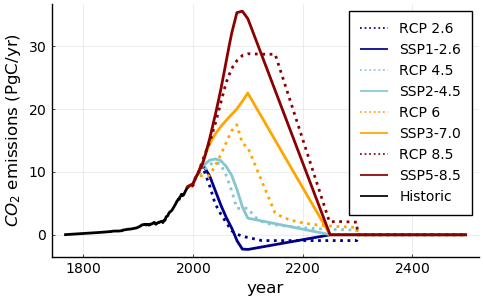

In [13]:
#-----------------------------------------------------------------------
colors = [palette(:blues)[2],palette(:ice)[200],palette(:heat)[2],palette(:heat)[3]]
p = plot(xtickfont=font(10), 
    ytickfont=font(10), 
    guidefont=font(12), 
    legendfont=font(10))
t_start = 1800
t_final = 2500
for i in 1:length(scenarios)
    time = [t for t in 1989:0.1:t_final]
    plot!(time,rcp_itp[i].(time), 
        label = rcp_names[i], lw=2,color=colors[i],ls=:dot)
    plot!(time,ssp_itp[i].(time), 
        label = ssp_names[i], lw=2,color=colors[i])
end
t_historic = [t for t in 1765:0.1:1989]
plot!(t_historic,rcp_itp[1].(t_historic),label="Historic",lc=:black,lw=2,size=(1.61*300,300))
ylabel!(L"CO_2"*" emissions (PgC/yr)")
xlabel!("year")

## Example 1: SURFER under RCP and SSP scenarios till 4000

In [14]:
sol_list_rcp = []
sol_list_ssp = []
for i in 1:4
    tspan = (1765.0,4000.0) # time interval
    # rcp
    u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI, 0.0, 0.0, 1.0, 1.0] # initial state vector
    sources = [rcp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!,u₀,tspan,sources)
    @time sol = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12)
    push!(sol_list_rcp,sol)
    #ssp
    u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI, 0.0, 0.0, 1.0, 1.0] # initial state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(model!,u₀,tspan,sources)
    @time sol = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12)
    push!(sol_list_ssp,sol)
end

 10.155296 seconds (45.01 M allocations: 2.170 GiB, 9.77% gc time)
  0.092223 seconds (208.92 k allocations: 8.403 MiB)
  0.002131 seconds (75.77 k allocations: 1.947 MiB)
  0.002535 seconds (86.73 k allocations: 2.194 MiB)
  0.001699 seconds (77.00 k allocations: 1.978 MiB)
  0.002471 seconds (91.34 k allocations: 2.310 MiB)
  0.001791 seconds (77.63 k allocations: 1.995 MiB)
  0.003617 seconds (94.41 k allocations: 2.387 MiB)


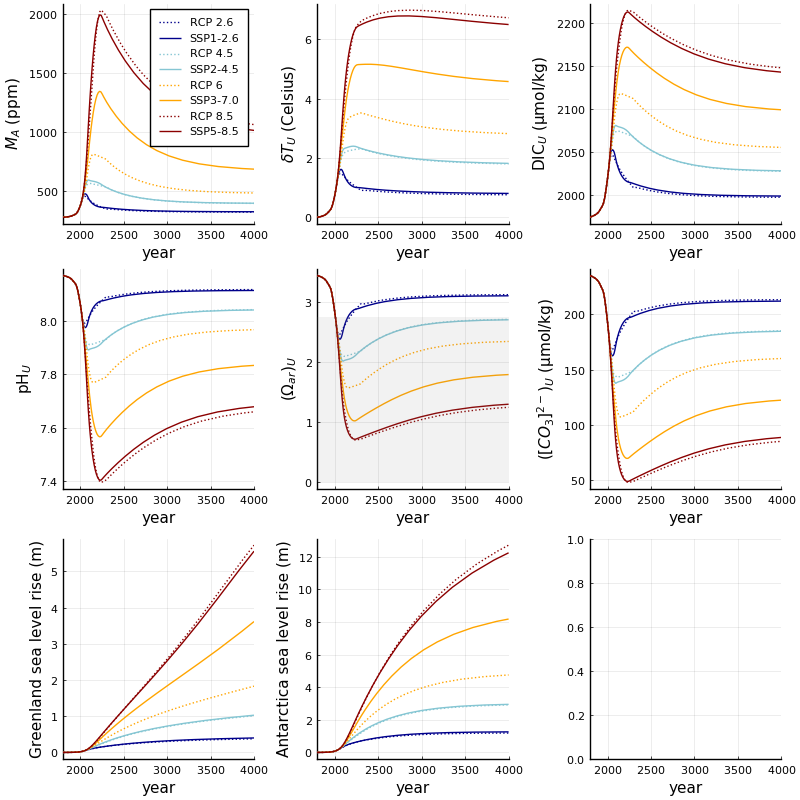

In [16]:
time_list = [t for t in 1765:0.1:4000]
p=plot(xrange=(1800,4000),xlabel="year", layout=(3,3),size=(800,800))
for iscen in 1:4
    time = sol_list_rcp[iscen].t
    Mat = sol_list_rcp[iscen][1,:]
    Mup = sol_list_rcp[iscen][2,:]
    δTup = sol_list_rcp[iscen][5,:]
    VG = sol_list_rcp[iscen][7,:]
    VA = sol_list_rcp[iscen][8,:]
    plot!(time,GtCtoppm.(Mat),color=colors[iscen],lw=1,label=rcp_names[iscen],ylabel=L"M_A"*" (ppm)",ls=:dot,subplot=1)
    plot!(time,δTup,color=colors[iscen],lw=1,label=false,ylabel=L"\delta T_U"*" (Celsius)",ls=:dot,subplot=2)
    plot!(time,DIC.(Mup),color=colors[iscen],lw=1,label=false,ylabel="DIC"*L"_U"*" (μmol/kg)",ls=:dot,subplot=3)
    plot!(time,pH.(Mup),color=colors[iscen],lw=1,label=false,ylabel="pH"*L"_U",ls=:dot,subplot=4)
    plot!(time,Ω.(Mup),color=colors[iscen],lw=1,label=false,ylabel=L"(\Omega_{ar})_U",ls=:dot,subplot=5)  
    plot!(time,CO3.(Mup),color=colors[iscen],lw=1,label=false,ylabel=L"([CO_3]^{2-})_U"*" (μmol/kg)",ls=:dot,subplot=6)
    plot!(time,SLRpotentialG*(1 .-VG),color=colors[iscen],lw=1,label=false,ylabel="Greenland sea level rise (m)",ls=:dot,subplot=7)
    plot!(time,SLRpotentialA*(1 .-VA),color=colors[iscen],lw=1,label=false,ylabel="Antarctica sea level rise (m)",ls=:dot,subplot=8)
    time = sol_list_ssp[iscen].t
    Mat = sol_list_ssp[iscen][1,:]
    Mup = sol_list_ssp[iscen][2,:]
    δTup = sol_list_ssp[iscen][5,:]
    VG = sol_list_ssp[iscen][7,:]
    VA = sol_list_ssp[iscen][8,:]
    plot!(time,GtCtoppm.(Mat),color=colors[iscen],lw=1,label=ssp_names[iscen],subplot=1)
    plot!(time,δTup,color=colors[iscen],lw=1,label=false,subplot=2)
    plot!(time,DIC.(Mup),color=colors[iscen],lw=1,label=false,subplot=3)
    plot!(time,pH.(Mup),color=colors[iscen],lw=1,label=false,subplot=4)
    plot!(time,Ω.(Mup),color=colors[iscen],lw=1,label=false,subplot=5)  
    plot!(time,CO3.(Mup),color=colors[iscen],lw=1,label=false,subplot=6)
    plot!(time,SLRpotentialG*(1 .-VG),color=colors[iscen],lw=1,label=false,subplot=7)
    plot!(time,SLRpotentialA*(1 .-VA),color=colors[iscen],lw=1,label=false,subplot=8)
end
hline!([2.75],label=false,legend=:bottomleft,lc=:gray,alpha=0,fill = (0, 0.1, :gray),subplot=5)
p

## Example 2: comparison with ZECMIP

### ZECMIP-B1 (lower emission scenario)

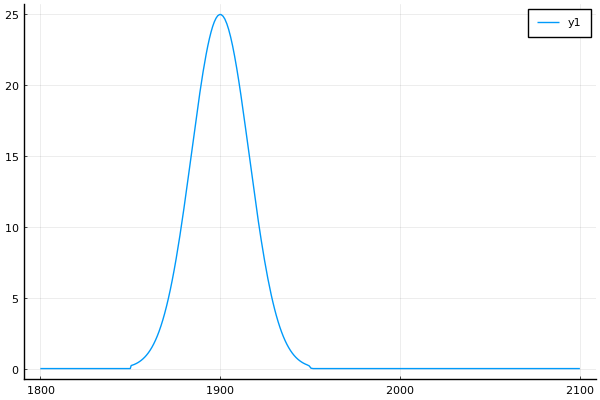

In [17]:
emissions_bell_data = readdlm("ZECMIP_data/ZECMIP-B1/co2emit_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv", ',', '\n',header=true)[1];
yearsbefore = [i for i in 1700:0.5:1850]
yearsafter = [i for i in 2850:0.5:4000]
before = zeros(length(yearsbefore));
after = zeros(length(yearsafter));
allyears = vcat(yearsbefore,emissions_bell_data[:,1],yearsafter)
allem= vcat(before,emissions_bell_data[:,2],after)
emBell = LinearInterpolation(allyears,allem);
years = [i for i in 1800:0.1:2100]
plot(years,emBell.(years))

  0.003565 seconds (80.04 k allocations: 2.083 MiB)


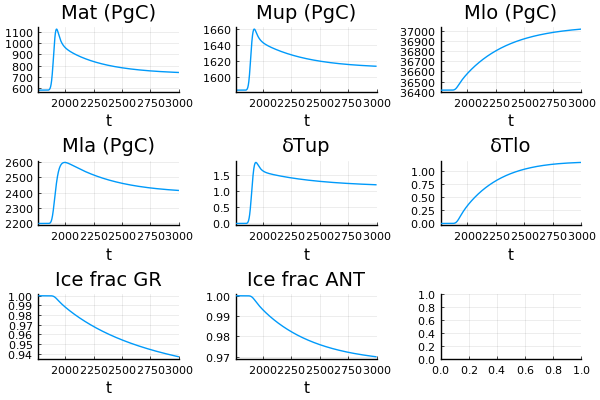

In [18]:
u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI,0.0, 0.0, 1.0, 1.0] # initial state vector
tspan = (1765.0,3000.0) # time interval
sources = [emBell, t -> 0.0] # [co2rate, so2rate]
prob = ODEProblem(model!,u₀,tspan,sources)
@time sol = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12);
p=plot(sol,layout=(3,3),label=false)
labels=["Mat (PgC)","Mup (PgC)","Mlo (PgC)","Mla (PgC)","δTup","δTlo","Ice frac GR","Ice frac ANT"]
for i in 1:length(labels)
    plot!(subplot=i, title=labels[i])
end
p

Import ZECMIP data to compare

In [21]:
co2data = []
cLanddata = []
DICdata = []
tasdata = []
for file in readdir("ZECMIP_data/ZECMIP-B1")
    datatype = split.(file,'_')[1]
    name = split.(file,'_')[2]
    data = readdlm("ZECMIP_data/ZECMIP-B1/"*file, ',', '\n',header=true)[1];
    if datatype == "co2"
        push!(co2data,[name,data])
    elseif datatype == "cLand"
        push!(cLanddata,[name,data])
    elseif datatype == "dissicos"
        push!(DICdata,[name,data])
    elseif datatype == "tas"
        push!(tasdata,[name,data])
    end
end

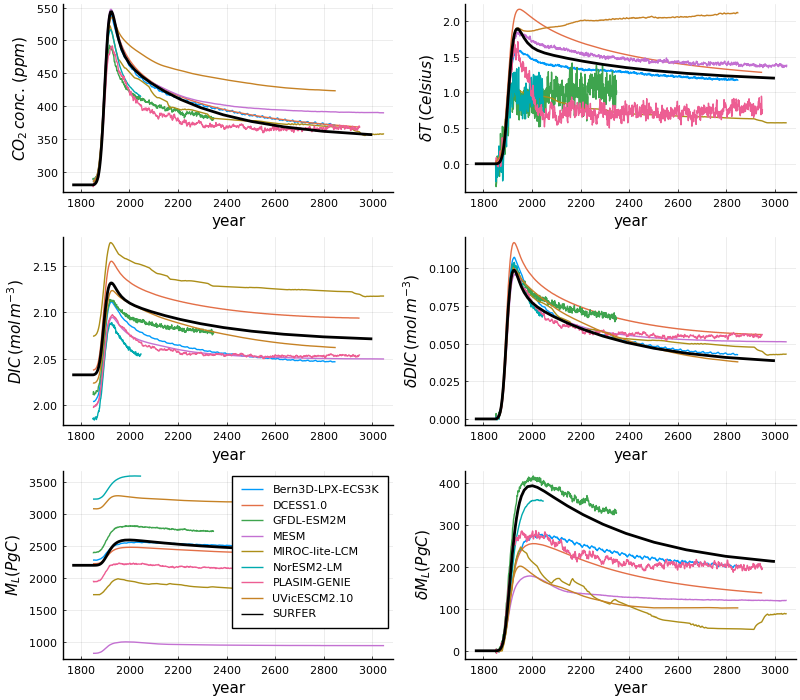

In [22]:
p=plot(layout=(3,2),size=(800,700),xlabel="year")
emiccolor = palette(:Greys_4)[2]
gsmcolor = palette(:Greys_4)[3]
ourcolor = :black
for i in 1:8
    name = co2data[i][1]
    time = co2data[i][2][:,1] .- co2data[i][2][1,1] .+ 1850.5  # year
    co2 = co2data[i][2][:,2] #ppm
    temp = tasdata[i][2][:,2] # kelvin or celsius
    cLand = cLanddata[i][2][:,2] #PgC
    dic = DICdata[i][2][:,2] # mol/m^3
    plot!(time,co2,label=false,subplot=1)
    plot!(time,temp .- temp[1],label=false,subplot=2)
    plot!(time,dic,label=false,subplot=3)
    plot!(time,dic .- dic[1],label=false,subplot=4)
    plot!(time,cLand,label=name,subplot=5)
    plot!(time,cLand .- cLand[1],label=false,subplot=6)
end
color = ourcolor
plot!(sol.t,GtCtoppm(sol[1,:]),label=false,ylabel=L"CO_2\, conc.\, (ppm)",lw=2,color=color,subplot=1)
plot!(sol.t,sol[5,:],label=false,ylabel=L"\delta T \, (Celsius)",lw=2,color=color,subplot=2)
plot!(sol.t,DIC(sol[2,:])*1.03E-3,label=false,ylabel=L"DIC\, (mol\, m^{-3})",lw=2,color=color,subplot=3)
plot!(sol.t,(DIC(sol[2,:]).-DIC(sol[2,1]))*1.03E-3,label=false,ylabel=L"\delta DIC\, (mol\, m^{-3})",lw=2,color=color,subplot=4)
plot!(sol.t,sol[4,:],label="SURFER",ylabel=L"M_L (PgC)",lw=2,color=color,subplot=5)
plot!(sol.t,sol[4,:] .- sol[4,1],label=false,ylabel=L"\delta M_L (PgC)",lw=2,color=color,subplot=6)
p

### B3 ZECMIP (higher emissions)

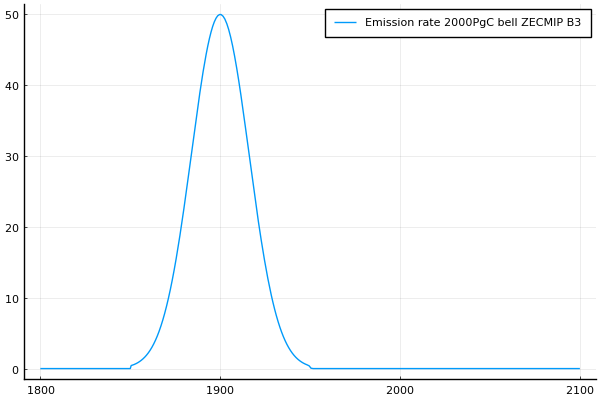

In [23]:
emissions_bell_data = readdlm("ZECMIP_data/ZECMIP-B3/co2emit_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv", ',', '\n',header=true)[1];
yearsbefore = [i for i in 1700:0.5:1850]
yearsafter = [i for i in 2850:0.5:4000]
before = zeros(length(yearsbefore));
after = zeros(length(yearsafter));
allyears = vcat(yearsbefore,emissions_bell_data[:,1],yearsafter)
allem= vcat(before,emissions_bell_data[:,2],after)
emBell = LinearInterpolation(allyears,allem);
years = [i for i in 1800:0.1:2100]
plot(years,emBell.(years),label="Emission rate 2000PgC bell ZECMIP B3")

run SURFER

  0.003573 seconds (84.35 k allocations: 2.193 MiB)


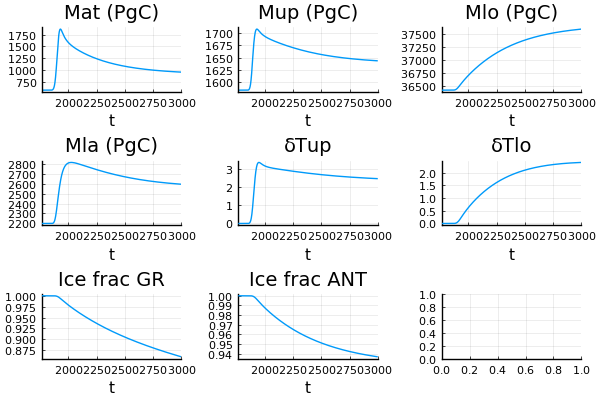

In [24]:
u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI,0.0, 0.0, 1.0, 1.0] # initial state vector
tspan = (1765.0,3000.0) # time interval
sources = [emBell, t -> 0.0] # [co2rate, so2rate]
prob = ODEProblem(model!,u₀,tspan,sources)
@time sol = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12);
p=plot(sol,layout=(3,3),label=false)
labels=["Mat (PgC)","Mup (PgC)","Mlo (PgC)","Mla (PgC)","δTup","δTlo","Ice frac GR","Ice frac ANT"]
for i in 1:length(labels)
    plot!(subplot=i, title=labels[i])
end
p

import ZECMIP-B3 data

In [25]:
co2data = []
cLanddata = []
DICdata = []
tasdata = []
for file in readdir("ZECMIP_data/ZECMIP-B3")
    datatype = split.(file,'_')[1]
    name = split.(file,'_')[2]
    data = readdlm("ZECMIP_data/ZECMIP-B3/"*file, ',', '\n',header=true)[1];
    if datatype == "co2"
        push!(co2data,[name,data])
    elseif datatype == "cLand"
        push!(cLanddata,[name,data])
    elseif datatype == "dissicos"
        push!(DICdata,[name,data])
    elseif datatype == "tas"
        push!(tasdata,[name,data])
    end
end

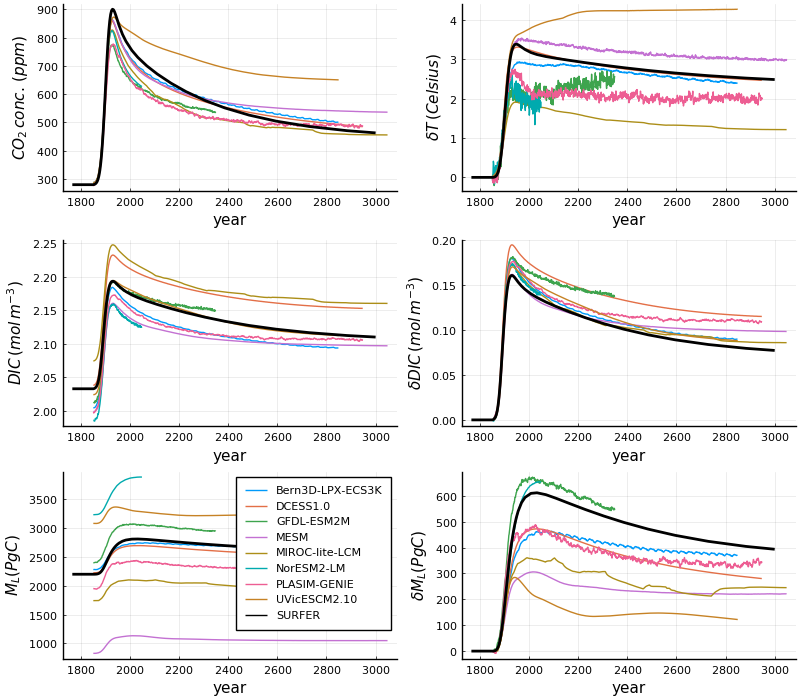

In [26]:
p=plot(layout=(3,2),size=(800,700),xlabel="year")
for i in 1:8
    name = co2data[i][1]
    time = co2data[i][2][:,1] .- co2data[i][2][1,1] .+ 1850.5  # year
    co2 = co2data[i][2][:,2] #ppm
    temp = tasdata[i][2][:,2] # kelvin or celsius
    cLand = cLanddata[i][2][:,2] #PgC
    dic = DICdata[i][2][:,2] # mol/m^3
    plot!(time,co2,label=false,subplot=1)
    plot!(time,temp .- temp[1],label=false,subplot=2)
    plot!(time,dic,label=false,subplot=3)
    plot!(time,dic .- dic[1],label=false,subplot=4)
    plot!(time,cLand,label=name,subplot=5)
    plot!(time,cLand .- cLand[1],label=false,subplot=6)
end
plot!(sol.t,GtCtoppm(sol[1,:]),label=false,ylabel=L"CO_2\, conc.\, (ppm)",lw=2,color=:black,subplot=1)
plot!(sol.t,sol[5,:],label=false,ylabel=L"\delta T \, (Celsius)",lw=2,color=:black,subplot=2)
plot!(sol.t,DIC(sol[2,:])*1.03E-3,label=false,ylabel=L"DIC\, (mol\, m^{-3})",lw=2,color=:black,subplot=3)
plot!(sol.t,(DIC(sol[2,:]).-DIC(sol[2,1]))*1.03E-3,label=false,ylabel=L"\delta DIC\, (mol\, m^{-3})",lw=2,color=:black,subplot=4)
plot!(sol.t,sol[4,:],label="SURFER",ylabel=L"M_L (PgC)",lw=2,color=:black,subplot=5)
plot!(sol.t,sol[4,:] .- sol[4,1],label=false,ylabel=L"\delta M_L (PgC)",lw=2,color=:black,subplot=6)
p

## Example 3: GeoMIP G6Sulfur

baseline scenarios

In [27]:
tspan = (1765.0,2100.0)
#SSP2-4.5
u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI, 0.0, 0.0, 1.0, 1.0] # initial state vector
sources = [ssp_itp[2], t->0,0] # [co2rate, so2rate]
prob = ODEProblem(model!,u₀,tspan,sources)
sol_4p5 = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12)
#SSP5-8.5
u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI, 0.0, 0.0, 1.0, 1.0] # initial state vector
sources = [ssp_itp[4], t->0,0] # [co2rate, so2rate]
prob = ODEProblem(model!,u₀,tspan,sources)
sol_8p5 = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12);

forcing of baseline scenarios

In [28]:
timelist = [i for i in 1765:0.01:2100]
forcing_4p5_t = LinearInterpolation(timelist,F.(sol_4p5(timelist)[1,:],0.0));
forcing_8p5_t = LinearInterpolation(timelist,F.(sol_8p5(timelist)[1,:],0.0));

Injections to lower high emission scenario forcing to medium emission scenario forcing

In [29]:
# define injections
function injections_G6Sulfur(t)
    SO2_needed = βSO2*( -log( max( (forcing_8p5_t(t) - forcing_4p5_t(t))/(αSO2) , 0)) )^(-1/γSO2)
    return SO2_needed
end

injections_G6Sulfur (generic function with 1 method)

In [30]:
tspan = (1765.0,2100.0)
#G6Sulfur 
u₀ = [Mat_PI, Mup_PI, Mlo_PI, Mla_PI, 0.0, 0.0, 1.0, 1.0] # initial state vector
sources = [ssp_itp[4], injections_G6Sulfur] # [co2rate, so2rate]
prob = ODEProblem(model!,u₀,tspan,sources)
sol_G6 = solve(prob,Rosenbrock23(),retol=1e-12,abstol=1e-12);

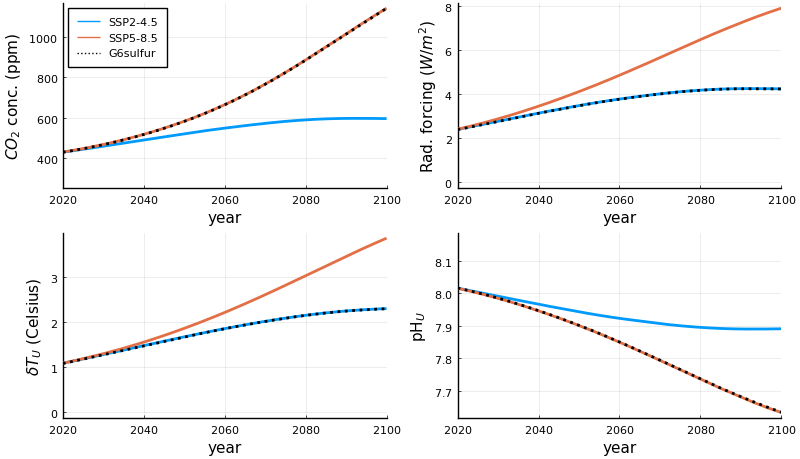

In [32]:
plot(layout=(2,2),size=(800,460))
#CO2
plot!(timelist,GtCtoppm(sol_4p5(timelist)[1,:]),subplot=1,label="SSP2-4.5",ylabel=L"CO_2"*" conc. (ppm)",xlabel="year",lw=2)
plot!(timelist,GtCtoppm(sol_8p5(timelist)[1,:]),subplot=1,label="SSP5-8.5",ylabel=L"CO_2"*" conc. (ppm)",xlabel="year",lw=2)
plot!(timelist,GtCtoppm(sol_G6(timelist)[1,:]),subplot=1,label="G6sulfur",ylabel=L"CO_2"*" conc. (ppm)",xlabel="year",color=:black,ls=:dot,lw=2)


#Radiative forcing
plot!(timelist,F.(sol_4p5(timelist)[1,:],0.0),ylabel="Rad. forcing "*L"(W/m^2)",xlabel="year",label=false,lw=2,subplot=2)
plot!(timelist,F.(sol_8p5(timelist)[1,:],0.0),lw=2,subplot=2,label=false)
plot!(timelist,F.(sol_G6(timelist)[1,:],injections_G6Sulfur.(timelist)),label=false,ls=:dot,lw=2
    ,lc=:black,subplot=2)
plot!(xrange=(2020,2100))

#temperature
plot!(timelist,sol_4p5(timelist)[5,:],subplot=3,label=false,ylabel=L"\delta T_U"*" (Celsius)",xlabel="year",lw=2)
plot!(timelist,sol_8p5(timelist)[5,:],subplot=3,label=false,lw=2)
plot!(timelist,sol_G6(timelist)[5,:],subplot=3,label=false,color=:black,ls=:dot,lw=2)

#pH
plot!(timelist,pH.(sol_4p5(timelist)[2,:]),subplot=4,label=false,ylabel="pH"*L"_U",xlabel="year",lw=2)
plot!(timelist,pH.(sol_8p5(timelist)[2,:]),subplot=4,label=false,lw=2)
plot!(timelist,pH.(sol_G6(timelist)[2,:]),subplot=4,label=false,color=:black,ls=:dot,lw=2)
